In [1]:
import sys
import os
sys.path.append(os.path.abspath('..'))

import joblib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from Scripts.Bulkparameters import load_blk_variables
from Scripts.cactusHandler import parse_cactus_file
from Scripts.model import create_dataframe_from_numpy_dict, label_cme_occurrences

from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score

clf = joblib.load('trained_cme_classifier.pkl')     # RandomForestClassifier

# === Step 2: Load new solar wind data ===
new_data = load_blk_variables('../data/BLK2/*.cdf', -1e31)  # <-- update path as needed

# === Step 3: Load new CME event times ===
new_cme_times = (parse_cactus_file('../data/cmejan2025.txt') +
                 parse_cactus_file('../data/cmefeb2025.txt') +
                 parse_cactus_file('../data/cmemar2025.txt') +
                 parse_cactus_file('../data/cmeapril2025.txt')
                )

# === Step 4: Convert new data dict to DataFrame ===
df_new = create_dataframe_from_numpy_dict(new_data)
df_new = label_cme_occurrences(df_new, new_cme_times)

df_new['delta_density'] = df_new['proton_density'].diff().fillna(0)
df_new['rolling_speed_mean'] = df_new['proton_bulk_speed'].rolling(window=15).mean().bfill()

# === Step 5: Feature selection and scaling ===
feature_cols = ['delta_density', 'rolling_speed_mean']
X_new = df_new[feature_cols].values

# === Step 6: Prediction ===
df_new['cme_pred'] = clf.predict(X_new)
df_new['cme_proba'] = clf.predict_proba(X_new)[:, 1]  # probability of CME
df_new['weighted_signal'] = df_new['cme_proba'].rolling(window=10, center=True).mean().fillna(0)

# === Step 7: Evaluation ===
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score

y_true = df_new['cme_label'].values
y_proba = clf.predict_proba(X_new)[:, 1]  # CME probability
threshold = 0.75
y_pred = (y_proba >= threshold).astype(int)

In [2]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import pandas as pd

def plot_weighted_signal(df, title="Weighted Signal vs Time", max_points=50000, threshold = 0.75):
    """
    Plots the weighted signal over time, highlighting actual CME events.

    Parameters:
    - df: DataFrame containing 'time', 'weighted_signal', and 'cme_label'
    - title: Plot title
    - max_points: Max number of time points to plot (for performance)
    """

    # Limit size to avoid crashes
    if len(df) > max_points:
        df = df.sample(n=max_points, random_state=42).sort_values('time')

    # Setup plotting style
    sns.set_style("whitegrid")
    plt.figure(figsize=(20, 5))

    # Plot weighted signal
    plt.plot(df['time'], df['weighted_signal'], label='Weighted Signal', color='#007acc', linewidth=1)

    from scipy.signal import find_peaks
    peaks, _ = find_peaks(df['weighted_signal'], height=threshold, distance=20)  # increase height and distance

# Plot them
    for p in peaks:
        plt.axvline(df.iloc[p]['time'], color='orange', linestyle='--', linewidth = 0.5)
    
    # Plot vertical lines for actual CME labels
    for idx, t in enumerate(df[df['cme_label'] == 1]['time']):
        plt.axvline(x=t, color='red', linestyle='--', linewidth=0.8, alpha=0.5,
                    label='Actual CME' if idx == 0 else "")

    plt.axhline(y=threshold, color='gray', linestyle='--', label=f'Threshold = {threshold}')

    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Weighted Signal")
    plt.legend()
    plt.tight_layout()
    plt.gcf().autofmt_xdate()
    plt.show()

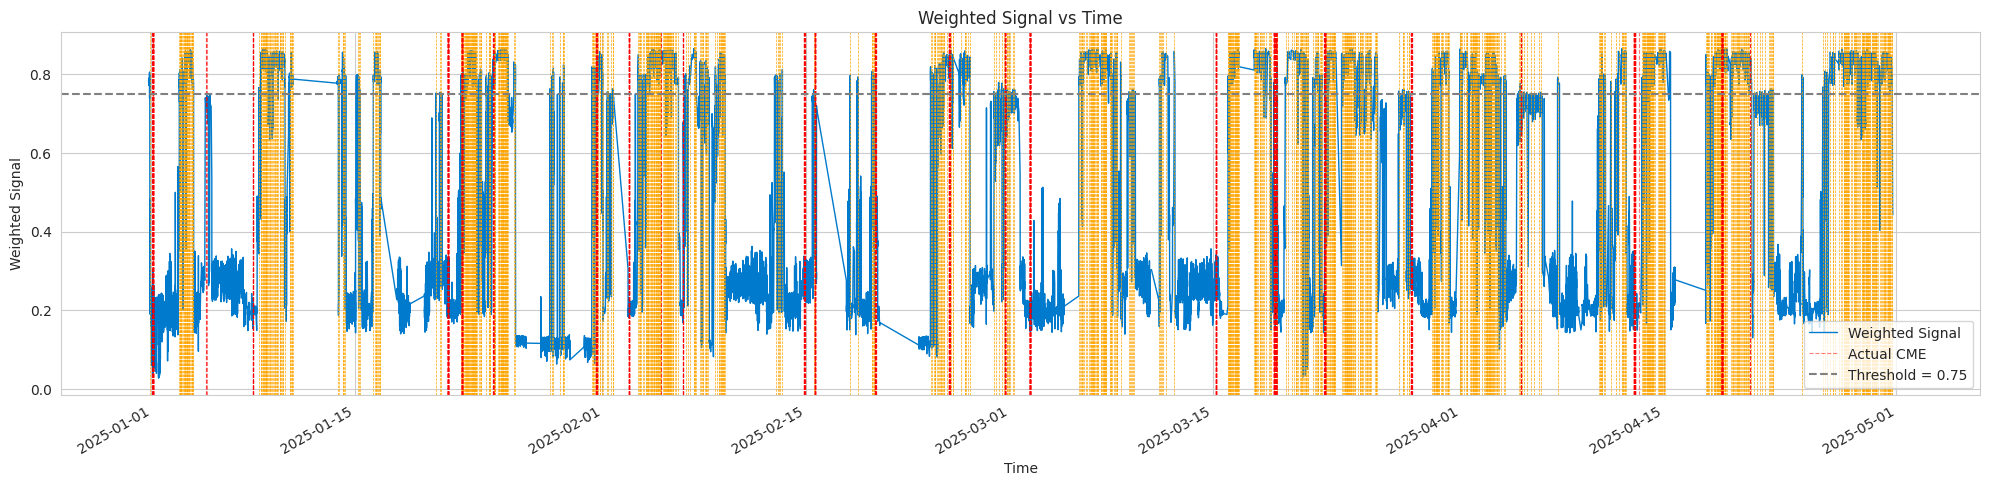

In [3]:
plot_weighted_signal(df_new)

In [4]:
from datetime import timedelta
def evaluate_cme_windows(df, cme_times, window_minutes=30):
    detected_windows = 0
    missed_windows = 0

    df = df.copy()
    df['time'] = pd.to_datetime(df['time'])
    df = df.sort_values('time')

    for t in cme_times:
        t = pd.Timestamp(t).tz_localize('UTC') if pd.Timestamp(t).tzinfo is None else pd.Timestamp(t).tz_convert('UTC')
        window_start = t - timedelta(minutes=window_minutes)
        window_end = t + timedelta(minutes=window_minutes)

        in_window = df[(df['time'] >= window_start) & (df['time'] <= window_end)]

        if (in_window['cme_pred'] == 1).any():
            detected_windows += 1
        else:
            missed_windows += 1

    total_windows = detected_windows + missed_windows
    print(f"\n=== CME Window Evaluation ===")
    print(f"Total CME windows: {total_windows}")
    print(f"Detected: {detected_windows}")
    print(f"Missed: {missed_windows}")
    print(f"Detection Rate: {detected_windows / total_windows:.2%}")


In [5]:
evaluate_cme_windows(df_new, new_cme_times)


=== CME Window Evaluation ===
Total CME windows: 29
Detected: 16
Missed: 13
Detection Rate: 55.17%
